In [138]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np

from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid

sns.set(rc={'figure.figsize':(8,6)})
sns.set_context("paper", font_scale=2) 
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings("ignore")

# Проклятье размерности

Пусть есть выборка из многомерного равномерного распределения на гиперкубе $[0, 1]^d$
Рассмотрим объект $u$ в начале координат и будем считать окрестностью объекта $u$ "подкуб" со стороной $\epsilon$: $[0, \epsilon]^d$.

C какой вероятностью объект выборки окажется в окрестности $u$? 

In [94]:
eps = 0.99

def generate_points(d):
    return np.random.uniform(size=([5000, d]))

In [96]:
np.mean(generate_points(d=1).max(-1) < eps)

0.991

In [110]:
np.mean(generate_points(d=3).max(-1) < eps)

0.9706

Посчитаем для произвольного d вероятность $p(x \in [0, \epsilon]^d)$ попасть в гиперкуб со стороной $\epsilon$

In [99]:
ds = []
probs = []
for d in range(1, 500):
    data = generate_points(d)
    ds.append(d)
    probs.append(np.mean(data.max(-1) < eps))
ds = np.array(ds)

Text(0, 0.5, 'Вероятность найти соседа')

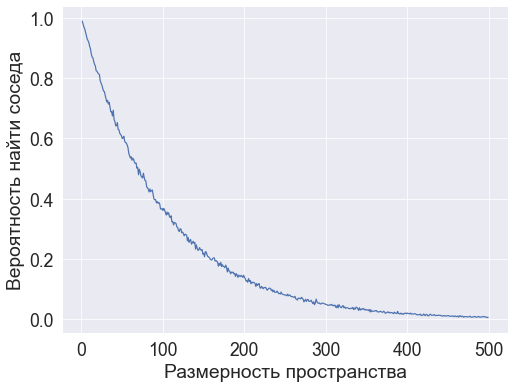

In [100]:
plt.plot(ds, probs)
plt.xlabel("Размерность пространства")
plt.ylabel("Вероятность найти соседа")

### Генерация набора данных 

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 


X, Y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_classes=3, 
                           n_redundant=0,
                           scale=1.5,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=250, 
                                                    random_state=0)

## Метод ближайшего соседа

In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

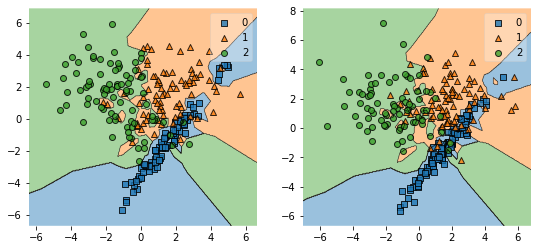

In [8]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))


plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])

plt.show()

In [9]:
from sklearn.metrics import classification_report

In [10]:
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        84
           1       0.73      0.78      0.75        88
           2       0.83      0.76      0.79        78

    accuracy                           0.81       250
   macro avg       0.81      0.81      0.81       250
weighted avg       0.81      0.81      0.81       250



## Метод k-ближайших соседей

______________________________
k=2
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        84
           1       0.70      0.84      0.77        88
           2       0.94      0.64      0.76        78

    accuracy                           0.81       250
   macro avg       0.84      0.81      0.81       250
weighted avg       0.83      0.81      0.81       250

______________________________
k=5
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        84
           1       0.76      0.74      0.75        88
           2       0.84      0.78      0.81        78

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250

______________________________
k=20
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        84
           1       0.74

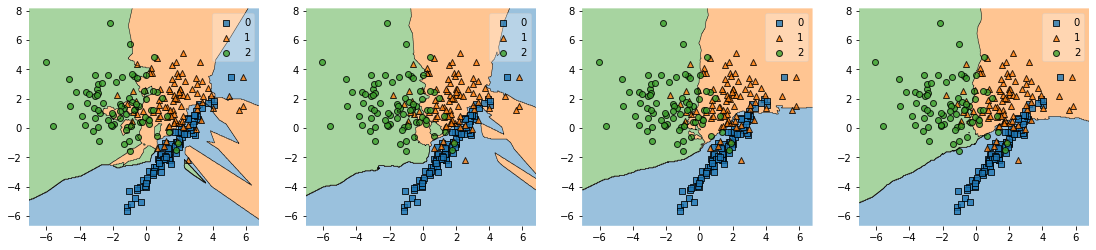

In [11]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

for i, n_neighbors in enumerate([2, 5, 20, 50]):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, Y_train)
    ax = fig.add_subplot(gs[i])
    plot_decision_regions(X_test, Y_test, model, ax=ax)
    
    print('_'*30)
    print(f'k={n_neighbors}')
    print(classification_report(Y_test, model.predict(X_test)))
    
plt.show()

In [12]:
from tqdm import tqdm_notebook

In [13]:
accuracy = []
for n_neighbors in tqdm_notebook(range(1, 50, 3)):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, Y_train)
    accuracy.append(np.mean(model.predict(X_test) == Y_test)) 

  0%|          | 0/17 [00:00<?, ?it/s]

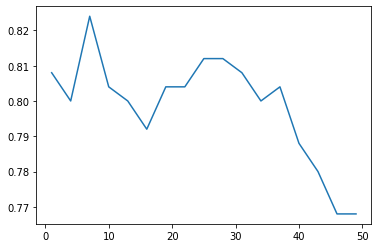

In [14]:
plt.plot(range(1, 50, 3), accuracy)

## Метод k-ближайших соседей с линейно убывающими весами

In [15]:
def linear_weights(distance):
    k = distance.shape[1]
    return ((k - np.arange(0, k))/k) * np.ones_like(distance)

______________________________
k=2
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        84
           1       0.73      0.78      0.75        88
           2       0.83      0.76      0.79        78

    accuracy                           0.81       250
   macro avg       0.81      0.81      0.81       250
weighted avg       0.81      0.81      0.81       250

______________________________
k=5
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        84
           1       0.75      0.75      0.75        88
           2       0.83      0.77      0.80        78

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.81       250

______________________________
k=20
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        84
           1       0.74

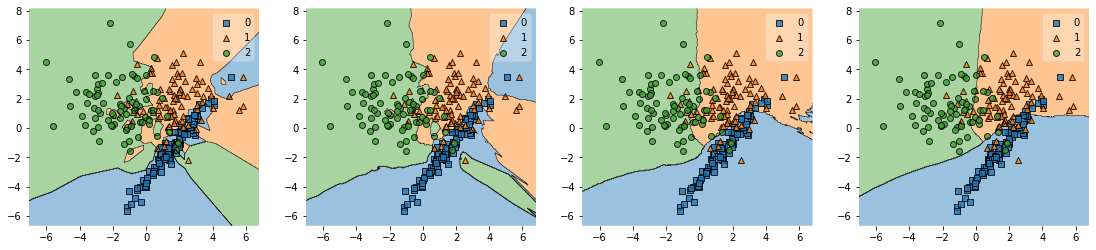

In [16]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

for i, n_neighbors in enumerate([2, 5, 20, 50]):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=linear_weights)
    model.fit(X_train, Y_train)
    ax = fig.add_subplot(gs[i])
    plot_decision_regions(X_test, Y_test, model, ax=ax)
    
    print('_'*30)
    print(f'k={n_neighbors}')
    print(classification_report(Y_test, model.predict(X_test)))
    
plt.show()

  0%|          | 0/17 [00:00<?, ?it/s]

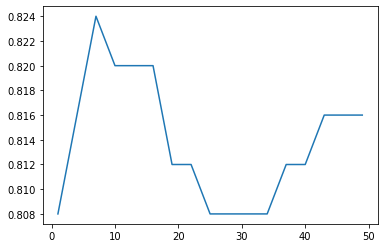

In [17]:
accuracy = []
for n_neighbors in tqdm_notebook(range(1, 50, 3)):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=linear_weights)
    model.fit(X_train, Y_train)
    accuracy.append( np.mean(model.predict(X_test) == Y_test)) 
plt.plot(range(1, 50, 3), accuracy)

## Окно Парзена

In [141]:
X, Y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_classes=3, 
                           n_redundant=0,
                           scale=1.5,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=250, 
                                                    random_state=0)

In [145]:
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

______________________________
k=0.5
              precision    recall  f1-score   support

           0       0.74      0.93      0.83        84
           1       0.73      0.69      0.71        88
           2       0.84      0.67      0.74        78

    accuracy                           0.76       250
   macro avg       0.77      0.76      0.76       250
weighted avg       0.77      0.76      0.76       250

______________________________
k=1
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        84
           1       0.76      0.73      0.74        88
           2       0.82      0.74      0.78        78

    accuracy                           0.80       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.80      0.80      0.80       250

______________________________
k=3
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        84
           1       0.7

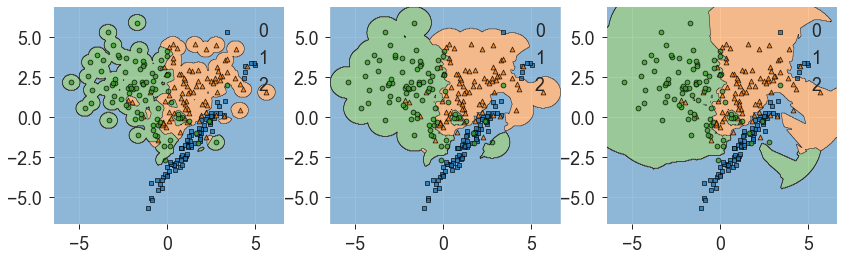

In [146]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

for i, h in enumerate([0.5, 1, 3]):
    model = KNeighborsClassifier(n_neighbors=5, weights=lambda x: K(x, h=h))
    model.fit(X_train, Y_train)
    ax = fig.add_subplot(gs[i])
    plot_decision_regions(X_train, Y_train, model, ax=ax)
    
    print('_'*30)
    print(f'k={h}')
    print(classification_report(Y_test, model.predict(X_test)))
    
plt.show()

### Генерация признаков на основе метода ближайших соседей

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from multiprocessing import Pool

In [74]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 


X, Y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_classes=2, 
                           n_redundant=0,
                           scale=1.5,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(pd.DataFrame(X), pd.Series(Y), 
                                                    test_size=250, 
                                                    random_state=0)

In [75]:
class NearestNeighborsFeats(BaseEstimator, ClassifierMixin):
    ''' 
        Этот класс реализует создание KNN признаков.
    '''

    def __init__(self, k_list, metric, n_jobs = 4,  n_classes=None, n_neighbors=None, eps=1e-10):
        self.n_jobs = n_jobs
        self.k_list = k_list
        self.metric = metric
        self.n_neighbors = n_neighbors or max(k_list)
        self.eps = eps
        self.n_classes_ = n_classes

    def fit(self, X, y):
        # Создание объекта-классификатора  
        self.NN = NearestNeighbors(n_neighbors=max(self.k_list),
                                   metric=self.metric,
                                   n_jobs=-1,
                                   algorithm='brute' if self.metric == 'cosine' else 'auto')
        self.NN.fit(X)

        # Сохраниение меток 
        self.y_train = y.values

        # Определение количества классов 
        self.n_classes = len(np.unique(y)) if self.n_classes_ is None else self.n_classes_

    def predict(self, X):
        '''
            Создание признаков для каждого объекта в наборе данных
        '''
        result = []
        for k in self.k_list:
            
            neighs_dist, neighs = self.NN.kneighbors(X)
            neighs_dist, neighs = neighs_dist[:, :k], neighs[:, :k] 

            neighs_y = self.y_train[neighs]

            # 1. Доля объектов каждого класса среди ближайших соседей
            fraction = np.mean(neighs_y, axis = 1)

            # 2. Минимальная дистанция до объектов каждого из классов

            # где y=1  не трогаем значение дистанции, где y=0 прибалвяем к дистанции np.inf
            ones = np.min(neighs_dist + np.where(neighs_y, 0, np.inf), axis =1)
            zeros = np.min(neighs_dist + np.where(neighs_y, np.inf, 0), axis =1)

            # 3. Средняя дистанция 

            mean_distance = np.median(neighs_dist, axis=1)

            # 4. Минимальная дистанция до объектов каждого класса деленная на расстояние до среднего объекта

            norm_ones = ones/(mean_distance + self.eps)

            norm_zeros = zeros/(mean_distance + self.eps)

            # 6. Средняя дистанция до объекта каждого класса из k ближайших соседей

            ones_mean = (np.sum(neighs_dist*neighs_y, axis=1) + self.eps) / np.sum(neighs_y, axis=1)

            mask = 1 * ~neighs_y.astype(bool)

            zeros_mean = (np.sum(neighs_dist*mask, axis=1) + self.eps) / np.sum(mask, axis=1)
            
            column_names = ['fraction_ones', 'min_distance_one', 'min_distance_zero',
                            'mean_distance', 'norm_min_distance_one', 'norm_min_distance_zero',
                            'mean_distance_one', 'min_distance_zero']
            
            result.append(pd.DataFrame(data = np.c_[[fraction, ones, zeros, mean_distance,
                                                      norm_ones, norm_zeros, ones_mean, zeros_mean]].T, 
                                        columns = column_names, 
                                        index = X.index).add_suffix(f'_{k}'))

        return pd.concat(result, axis=1)

In [76]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, 
                                                     test_size=125, 
                                                     random_state=0)

In [77]:
nnf.fit(X_valid, Y_valid)

In [79]:
train_features = nnf.predict(X_train)
test_features = nnf.predict(X_test)

In [82]:
train_features.replace({np.inf: 0}, inplace=True)
test_features.replace({np.inf: 0}, inplace=True)

In [83]:
lr = LogisticRegression()

In [84]:
lr.fit(train_features, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
print(classification_report(Y_test, lr.predict(test_features)))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89       119
           1       0.96      0.83      0.89       131

    accuracy                           0.89       250
   macro avg       0.90      0.90      0.89       250
weighted avg       0.90      0.89      0.89       250



####  EM-алгоритм

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
plt.style.use('seaborn')

/tmp/ipykernel_3958/1912122766.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# Первый кластер данных
num1, mu1, var1 = 400, [0.5, 0.5], [1, 3]
X1 = np.random.multivariate_normal(mu1, np.diag(var1), num1)

# Второй кластер данных
num2, mu2, var2 = 600, [5.5, 2.5], [2, 2]
X2 = np.random.multivariate_normal(mu2, np.diag(var2), num2)

# Третий кластер данных
num3, mu3, var3 = 1000, [1, 7], [6, 2]
X3 = np.random.multivariate_normal(mu3, np.diag(var3), num3)

# слить вместе
X = np.vstack((X1, X2, X3))

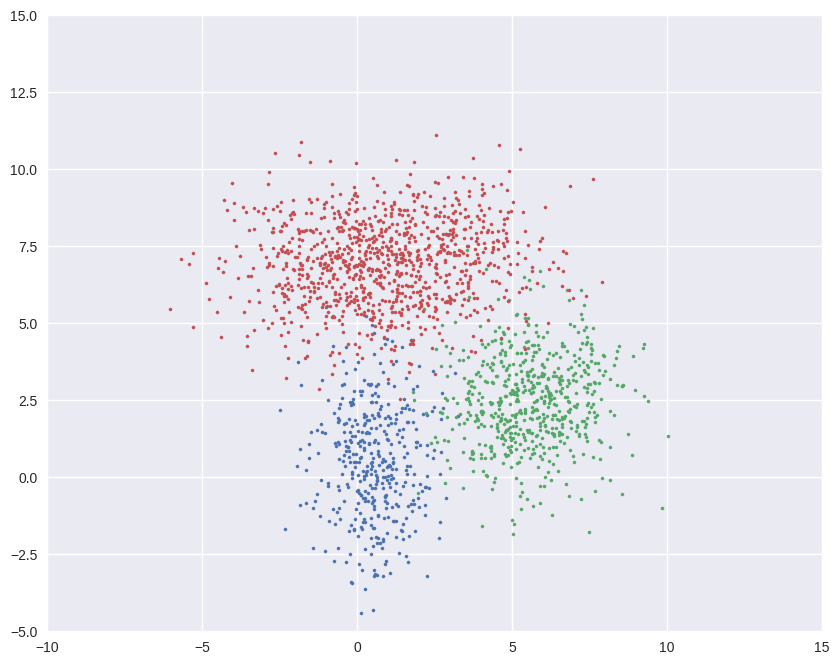

In [3]:
plt.figure(figsize=(10, 8))
plt.axis([-10, 15, -5, 15])
plt.scatter(X1[:, 0], X1[:, 1], s=5)
plt.scatter(X2[:, 0], X2[:, 1], s=5)
plt.scatter(X3[:, 0], X3[:, 1], s=5)
plt.show()

In [19]:
n_clusters = 4
n_points = len(X)

Mu = [[-2, -1], [5, -1], [0, 12], [0, 0]] # /theta
Var = [[1, 1], [1, 1], [1, 1],  [1, 1]] # /theta
Pi = [1 / n_clusters] * 4  # Априорные вероятности компонент

In [20]:
W = np.ones((n_points, n_clusters)) / n_clusters  # латентные переменные
Pi = W.sum(axis=0) / W.sum() 

In [21]:
def update_W(X, Mu, Var, Pi):
    n_points, n_clusters = len(X), len(Pi)
    pdfs = np.zeros(((n_points, n_clusters)))
    for i in range(n_clusters):
        pdfs[:, i] = Pi[i] * multivariate_normal.pdf(X, Mu[i], np.diag(Var[i]))
    W = pdfs / pdfs.sum(axis=1).reshape(-1, 1)
    return W

def update_Pi(W):
    Pi = W.sum(axis=0) / W.sum()
    return Pi

In [22]:
def logLH(X, Pi, Mu, Var):
    n_points, n_clusters = len(X), len(Pi)
    pdfs = np.zeros(((n_points, n_clusters)))
    for i in range(n_clusters):
        pdfs[:, i] = Pi[i] * multivariate_normal.pdf(X, Mu[i], np.diag(Var[i]))
    return np.mean(np.log(pdfs.sum(axis=1)))

In [29]:
def plot_clusters(X, Mu, Var, Mu_true=None, Var_true=None):
    colors = ['b', 'g', 'r', 'y']
    n_clusters = len(Mu)
    plt.figure(figsize=(10, 8))
    plt.axis([-10, 15, -5, 15])
    plt.scatter(X[:, 0], X[:, 1], s=5)
    ax = plt.gca()
    for i in range(n_clusters):
        plot_args = {'fc': 'None', 'lw': 2, 'edgecolor': colors[i], 'ls': ':'}
        ellipse = Ellipse(Mu[i], 3 * Var[i][0], 3 * Var[i][1], **plot_args)
        ax.add_patch(ellipse)
#     if (Mu_true is not None) & (Var_true is not None):
#         for i in range(n_clusters):
#             plot_args = {'fc': 'None', 'lw': 2, 'edgecolor': colors[i], 'alpha': 0.5}
#             ellipse = Ellipse(Mu_true[i], 3 * Var_true[i][0], 3 * Var_true[i][1], **plot_args)
#             ax.add_patch(ellipse)         
    plt.show()

In [30]:
def update_Mu(X, W):
    n_clusters = W.shape[1]
    Mu = np.zeros((n_clusters, 2))
    for i in range(n_clusters):
        Mu[i] = np.average(X, axis=0, weights=W[:, i])
    return Mu

def update_Var(X, Mu, W):
    n_clusters = W.shape[1]
    Var = np.zeros((n_clusters, 2))
    for i in range(n_clusters):
        Var[i] = np.average((X - Mu[i]) ** 2, axis=0, weights=W[:, i])
    return Var

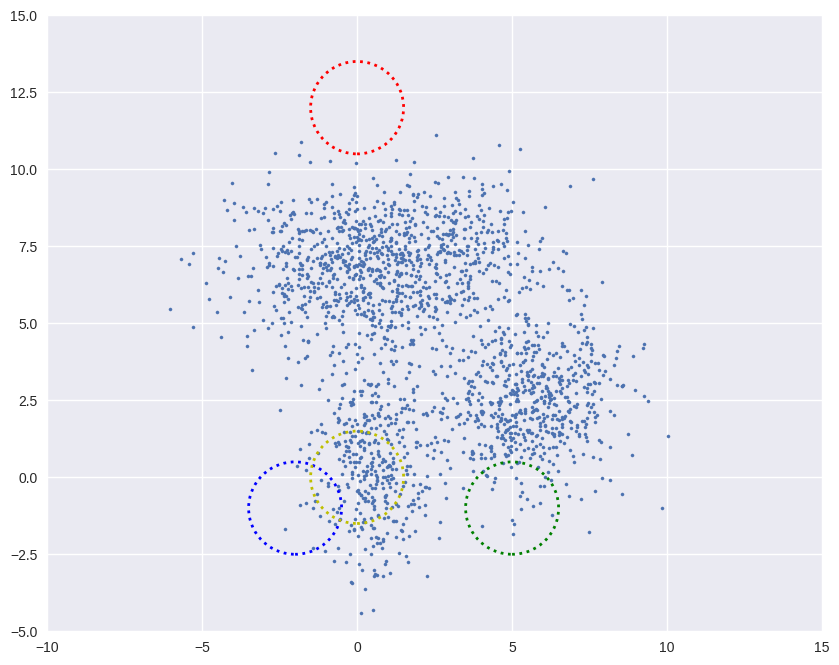

log-likehood:-13.182


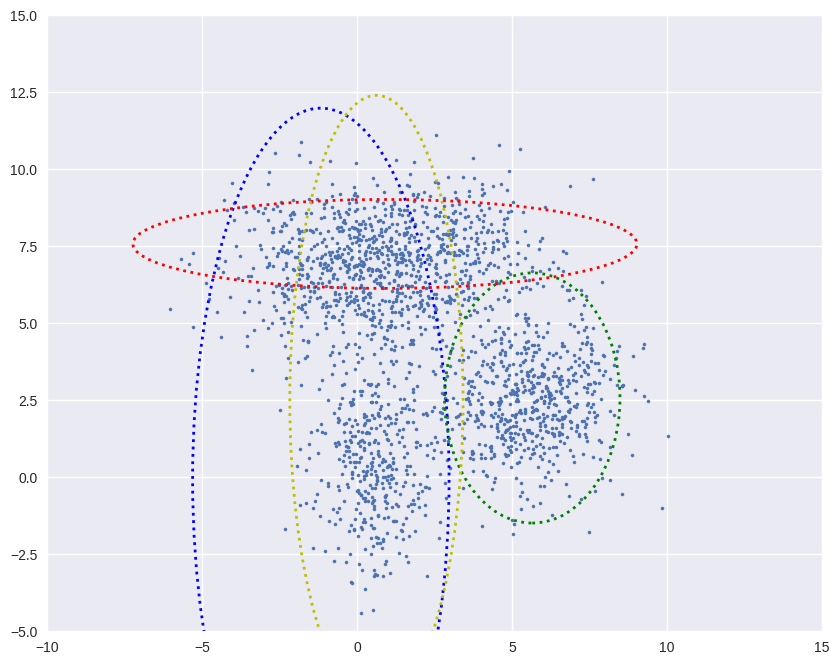

log-likehood:-4.791


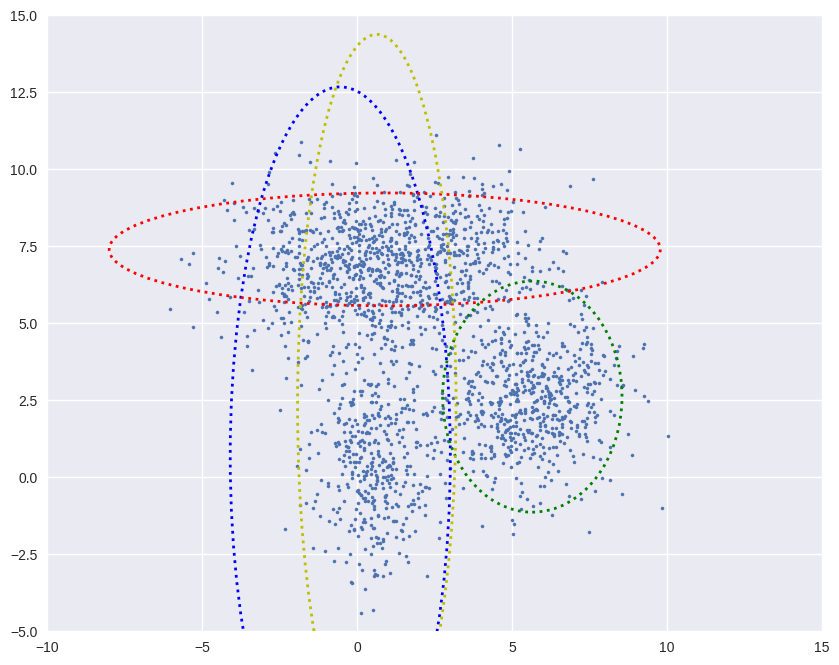

log-likehood:-4.759


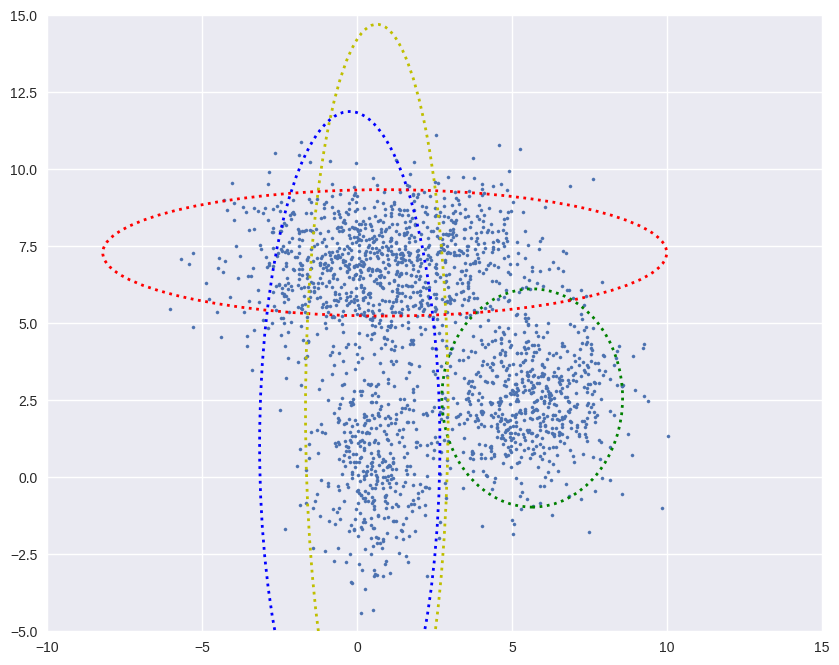

log-likehood:-4.747


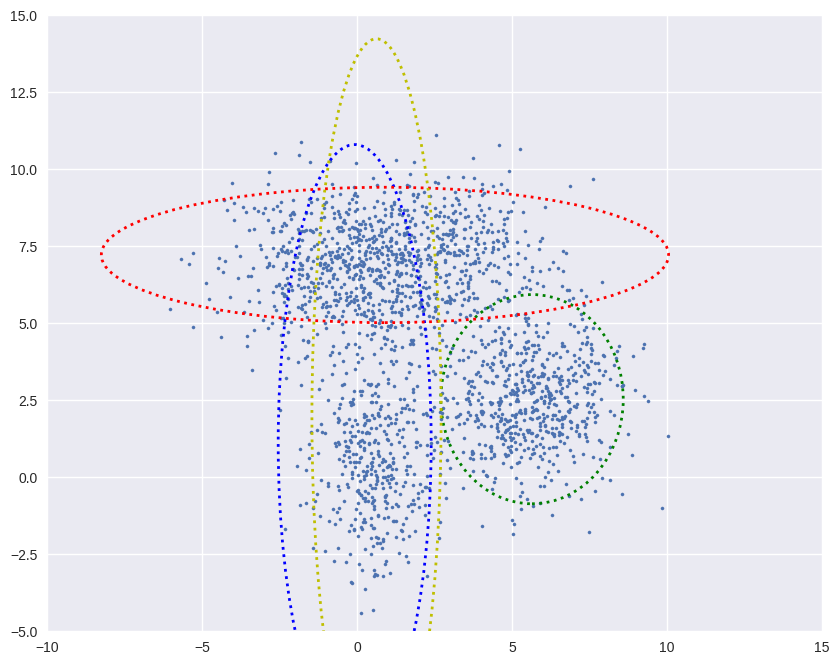

log-likehood:-4.740


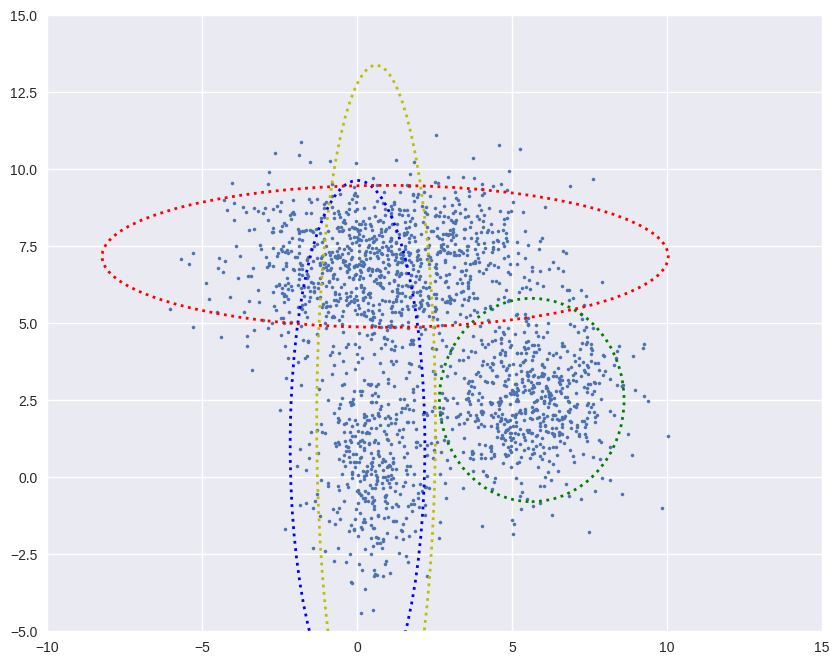

log-likehood:-4.735


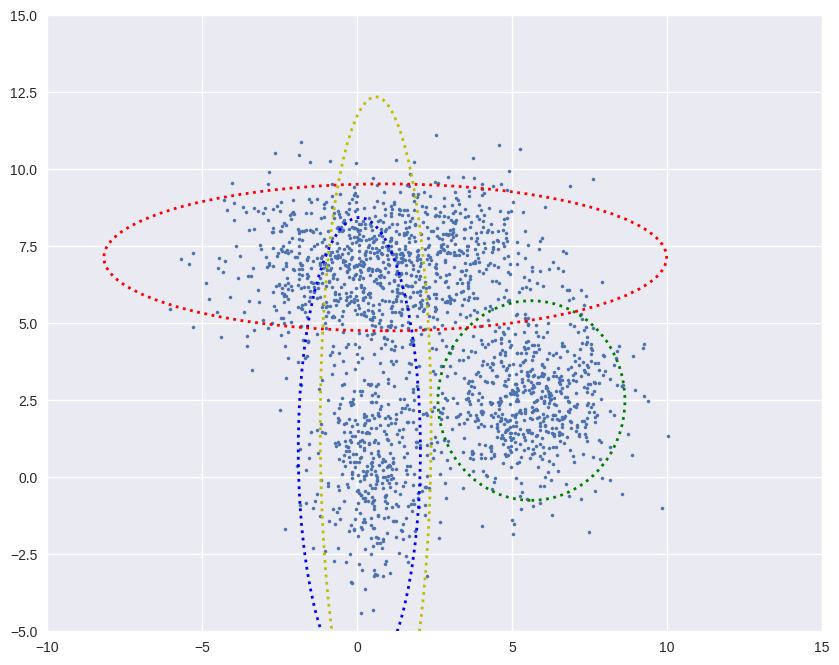

log-likehood:-4.731


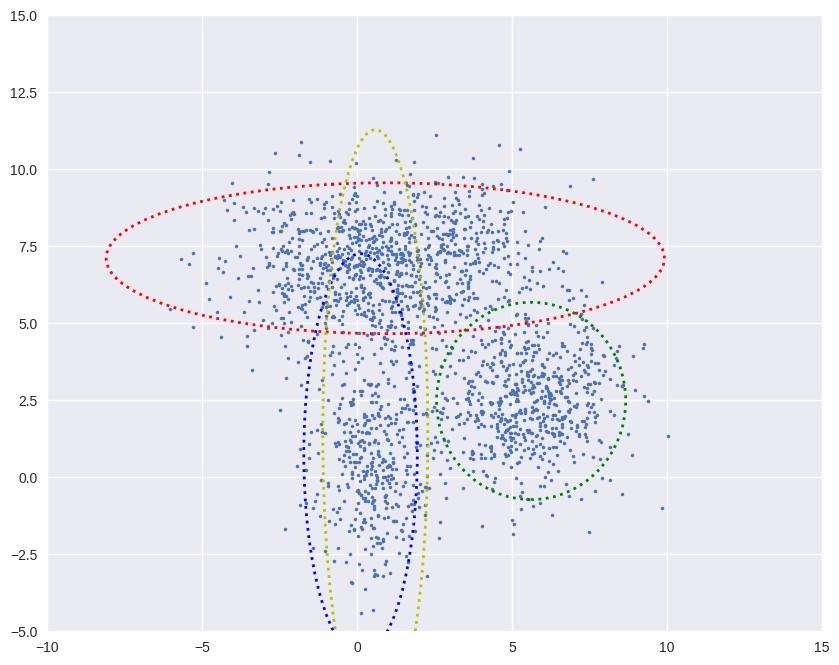

log-likehood:-4.727


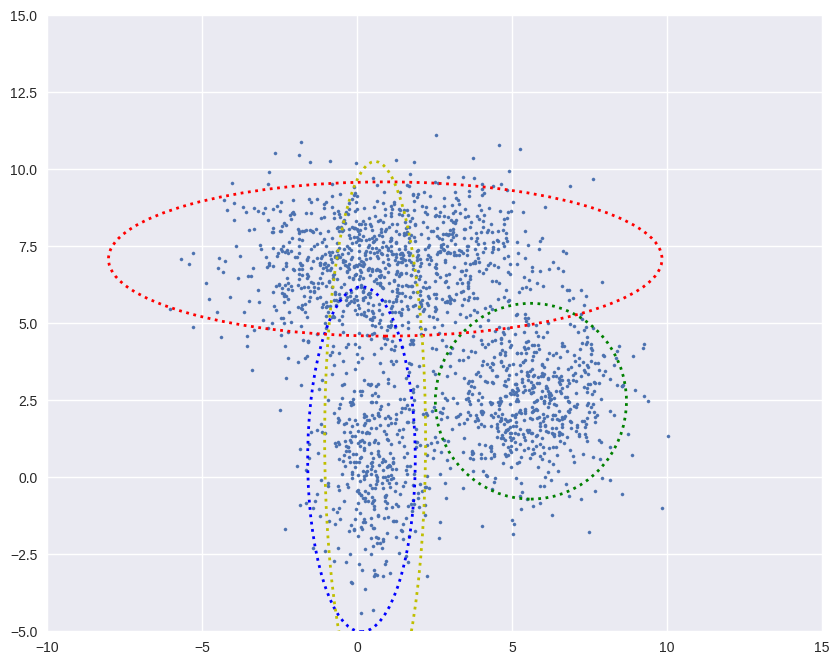

log-likehood:-4.724


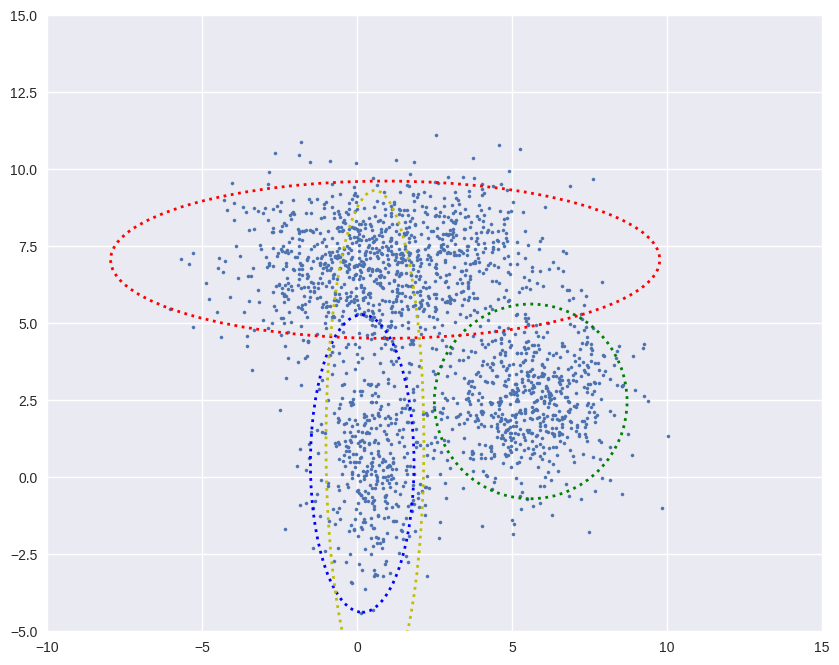

log-likehood:-4.722


In [31]:
loglh = []
for i in range(10):
    
    plot_clusters(X, Mu, Var, [mu1, mu2, mu3], [var1, var2, var3])
    
    loglh.append(logLH(X, Pi, Mu, Var))
    print('log-likehood:%.3f'%loglh[-1])
        
    # Expectation
    W = update_W(X, Mu, Var, Pi)
    
    # Maximization
    Pi = update_Pi(W)
    Mu = update_Mu(X, W)
    Var = update_Var(X, Mu, W)